In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import transforms, datasets

In [5]:
from fastai.vision import *
from fastai.metrics import accuracy

## Resnet50 CNN

In [6]:
PATH = "/project/DSone/ss4yd/msds_normed_data/combined_data/"
sz=256
tfms = get_transforms(do_flip=True, flip_vert=True, max_zoom=1.1)
data = (ImageList.from_folder(PATH)
        .split_by_folder()          
        .label_from_folder()
        .transform(tfms, size=sz)
        .databunch(bs=16)
        .normalize(imagenet_stats))

class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1,1)
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)
    
    def forward(self, x): 
        return torch.cat([self.mp(x), self.ap(x)], 1)
    
    
custom_head = nn.Sequential(
                            AdaptiveConcatPool2d(),
                            Flatten(), 
                            nn.BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                            nn.Dropout(p=0.25),
                            nn.Linear(in_features=4096, out_features=512, bias=True),
                            nn.ReLU(),
                            nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                            nn.Dropout(p=0.5),
                            nn.Linear(in_features=512, out_features=10, bias=True),
                            nn.ReLU(),
                            nn.Linear(in_features=10, out_features=3, bias=True),
                            nn.LogSoftmax(dim=1)
                           )

In [7]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy, custom_head=custom_head)
learn.model = torch.nn.DataParallel(learn.model)
# learn.load('resnet_10_output_5_epoch')

In [5]:
# learn.model

In [8]:
# training without unfreezing
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.263840,0.273234,0.914925,1:04:16
1,0.204727,0.198991,0.940396,1:05:32


In [ ]:
learn.save('resnet_retrained_2ep_combined_1000')

In [9]:
interp = ClassificationInterpretation.from_learner(learn)

(None, None)

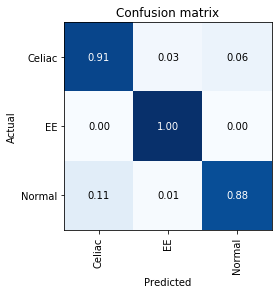

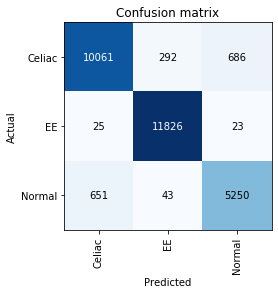

In [10]:
interp.plot_confusion_matrix(normalize=True), interp.plot_confusion_matrix(normalize=False)

In [11]:
learn.unfreeze()

learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


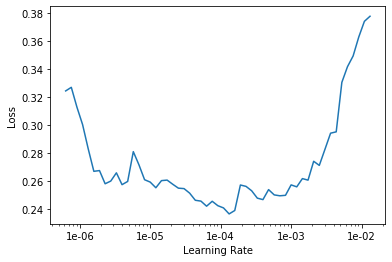

In [13]:
# learn.load('resnet_retrained_2ep_combined_1000')

learn.lr_find()
learn.recorder.plot()

In [14]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.219610,3.697010,0.908930,44:51


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
learn.save('resnet_retrained_5ep_combined_1000')

In [16]:
interp = ClassificationInterpretation.from_learner(learn)

(None, None)

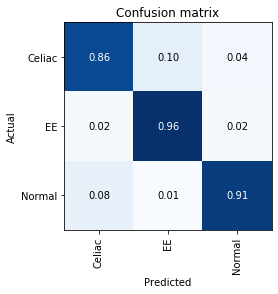

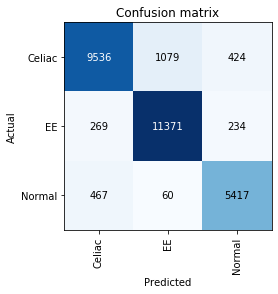

In [17]:
interp.plot_confusion_matrix(normalize=True), interp.plot_confusion_matrix(normalize=False)

## Get Gradcams

In [18]:
from gradcam import GradCam
import os
import pandas as pd
import random

learn2 = cnn_learner(data, models.resnet50, metrics=accuracy, custom_head=custom_head)
learn2.load('resnet_retrained_5ep_combined_1000')

Learner(data=ImageDataBunch;

Train: LabelList (109244 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Celiac,Celiac,Celiac,Celiac,Celiac
Path: /project/DSone/ss4yd/msds_normed_data/combined_data;

Valid: LabelList (28857 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Celiac,Celiac,Celiac,Celiac,Celiac
Path: /project/DSone/ss4yd/msds_normed_data/combined_data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [27]:
train_path='/project/DSone/ss4yd/msds_normed_data/iimac_data/valid/iimac_normal_normed/'
save_path='/project/GutIntelligenceLab/ss4yd/seem_msds_gradcams/iimac_celiac_normed/'
t1 = os.listdir(train_path)
dfb1 = pd.DataFrame(t1,columns=['imgs'])
dfb1['roots']=dfb1['imgs'].apply(lambda x: x.split('__')[0])
dfb1['source_paths'] = train_path+dfb1['imgs']

In [28]:
if not os.path.exists(save_path):
    os.mkdir(save_path)

for t in pd.unique(dfb1.roots):
    tdf = dfb1[dfb1.roots==t]
    tdf = tdf.sample(n=20, replace=True)
    print(t)
    for img_path in tdf['source_paths']:
        name = img_path.split('/')[-1]
        pat_name = name.split('.')[0].split('__')[0]
        save_folder=os.path.join(save_path, pat_name)
        if not os.path.exists(save_folder):
            os.mkdir(save_folder)
        img = open_image(img_path);
        gcam = GradCam.from_one_img(learn2,img)
        fig = gcam.plot()
        fig.savefig(save_folder+'/'+name)
        plt.close()

IIMAC_158_01
IIMAC_030


## Get IIMAC predictions

In [32]:
PATH = '/project/GutIntelligenceLab/ss4yd/msds_normed_data/iimac_data/'
data2 = (ImageList.from_folder(PATH)
#         .split_none()  
         .split_by_folder() 
        .label_from_folder()
        .transform(tfms, size=sz)
        .databunch(bs=32)
        .normalize(imagenet_stats))

In [33]:
pred_list= []
pred_soft_list=[]
for img in data2.valid_ds.x:
#     img = data.train_ds.x
    _, pred, pred_soft = learn.predict(img)
    pred, pred_soft= pred.numpy(),pred_soft.numpy()
    pred_list.append(pred)
    pred_soft_list.append(pred_soft)

celdf = pd.DataFrame()
celdf['preds']=pred_list
celdf=pd.concat((celdf, pd.DataFrame(pred_soft_list)), axis=1)
celdf['paths']=data2.valid_ds.x.items
celdf.head()

,preds,0,1,2,paths
0,2,0.204186,0.030655,0.765159,/project/GutIntelligenceLab/ss4yd/msds_normed_...
1,2,0.122674,0.006625,0.870702,/project/GutIntelligenceLab/ss4yd/msds_normed_...
2,2,0.028135,0.003331,0.968534,/project/GutIntelligenceLab/ss4yd/msds_normed_...
3,0,0.723206,0.005802,0.270991,/project/GutIntelligenceLab/ss4yd/msds_normed_...
4,2,0.062336,0.000587,0.937077,/project/GutIntelligenceLab/ss4yd/msds_normed_...


In [34]:
celdf.to_csv('./cm_retrained_patch_level_valid.csv', index=False)